# TP2: Críticas cinematográficas
 - 75.06 - Organización de Datos FiUBA - 2023-1c
 - Grupo11: Datatack
 - Integrante: Facundo de la plata - 100558


In [73]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix


In [74]:
ds_test = pd.read_csv("./datasets/test.csv")
ds_train = pd.read_csv("./datasets/train.csv")
ds_train_original = ds_train.copy()
ds_test_original = ds_test.copy()

In [75]:
ds_train_filtrado = ds_train = pd.read_csv("./datasets/ds_train_filtrado.csv")

In [3]:
ds_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Preprocesamiento

Reviso si hay reseñas en inglés

In [4]:
filtered_df = ds_train[ds_train['review_es'].str.contains('worst', case=False)]
filtered_df

,ID,review_es,sentimiento
278,278,I watched this movie for the hot guy--and even...,negativo
286,286,There have been many documentaries that I have...,positivo
312,312,Note to self Never ever ever again watch a ser...,negativo
365,365,"Years ago, when DARLING LILI played on TV, it ...",negativo
410,410,I firmly believe that the best Oscar ceremony ...,negativo
...,...,...,...
47275,47275,"The Governess was, by far, a very pitiful film...",negativo
47354,47354,"For most people, RoboCop 3 is the film that re...",negativo
48396,48396,With this movie I was really hoping that the i...,negativo
48540,48540,Four tales of terror regarding the events at a...,positivo


In [5]:
from langdetect import detect

In [6]:
# Función para detectar el idioma de una cadena de texto
def detectar_idioma(texto):
    try:
        idioma = detect(texto)
        return idioma
    except:
        return None

# Aplicar la detección de idioma a una columna en el DataFrame
ds_train['idioma'] = ds_train['review_es'].apply(detectar_idioma)

# Filtrar las filas que no están en español
filtered_df = ds_train[ds_train['idioma'] != 'es']

# Mostrar las filas filtradas
print(filtered_df)

          ID                                          review_es sentimiento   
156      156  From the film's first shot - Keira Knightley a...    negativo  \
249      249  'Airport 4' is basically a slopped together me...    negativo   
250      250  Supposedly a "social commentary" on racism and...    negativo   
263      263  There is a difference between a "film," and a ...    negativo   
264      264  please re-watch all 3 series and do not go see...    negativo   
...      ...                                                ...         ...   
49772  49772  CitizenX(1995) is the developing world's answe...    positivo   
49792  49792  Thirty years after its initial release, the th...    positivo   
49833  49833  THE SHOP AROUND THE CORNER is one of the sweet...    positivo   
49861  49861  OK OK, it might be hard to put the entirety of...    negativo   
49948  49948  It is the early morning of our discontent, and...    negativo   

      idioma  
156       en  
249       en  
250   

In [17]:
ds_train['idioma'].value_counts()

idioma
es    48180
en     1817
fr        1
it        1
id        1
Name: count, dtype: int64

Vuelvo a ejecutar la detección de idioma para las que no son español

In [21]:
filtered_df = ds_train[ds_train['idioma'] != 'es']
filtered_df.loc[:, 'idioma'] = filtered_df['review_es'].apply(detectar_idioma)
filtered_df['idioma'].value_counts()

idioma
en    1817
es       2
id       1
Name: count, dtype: int64

Armo el dataset con las reseñas en español

In [27]:
ds_train_filtrado = ds_train[ds_train['idioma'] == 'es']
filas_es = filtered_df[filtered_df['idioma'] == 'es']
ds_train_filtrado = pd.concat([ds_train_filtrado, filas_es])
ds_train_filtrado['idioma']
ds_train_filtrado = ds_train_filtrado.drop('idioma', axis=1)

Encoding: Etiqueto el sentimiento con 0 y 1

In [76]:
ds_train_filtrado['sentimiento'] = ds_train_filtrado['sentimiento'].replace({'positivo': 1, 'negativo': 0})

In [54]:
ds_train_filtrado.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1
3,3,"Básicamente, hay una familia donde un niño peq...",0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


Guardo el dataset filtrado

In [77]:
ds_train_filtrado.to_csv('./datasets/ds_train_filtrado.csv', index=False)

In [78]:
#Genero los conjuntos de train y de test

x_train, x_test, y_train, y_test = train_test_split(ds_train_filtrado['review_es'],
                                                    ds_train_filtrado['sentimiento'], 
                                                    test_size=0.3, 
                                                    random_state=25,
                                                    shuffle=True
                                                    ) #semilla)


Veo la cantidad de palabras

In [56]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_test)
palabras = vectorizer.get_feature_names_out()

# Imprimir las palabras
print(palabras.size)

85642


Voy a limitarlas a 40.000 para evitar el overfitting

In [79]:
from nltk.corpus import stopwords

stop_words = stopwords.words('spanish')
stop_words.extend(['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvieramos', 'tuviesemos'])
# Agregué estas palabras porque se generaban al vectorizar y me generaban un warning

In [80]:
vectorizer = TfidfVectorizer(max_features=40000, stop_words=stop_words, strip_accents='ascii')
vectorizer.fit(x_test)

TfidfVectorizer(max_features=40000,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='ascii')

In [81]:
palabras = vectorizer.get_feature_names_out()

# Imprimir las palabras
print(palabras.size)

40000


In [85]:
guardar_modelo(vectorizer, './modelos/vectorizer.sav')

Funciones útiles:

In [14]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred, digits=3))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [82]:
import pickle

def guardar_modelo(model, filename):
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

In [83]:
def guardar_prediccion(y_prediccion, ds_test, name):
    sub = pd.DataFrame(ds_test)
    submition=pd.DataFrame(y_prediccion)
    submition.rename(columns={0: "sentimiento"})
    sub["sentimiento"] = submition
    sub.drop('review_es', axis=1,  inplace=True)
    sub['sentimiento'] = sub['sentimiento'].replace({1:'positivo', 0: 'negativo'})
    sub.to_csv(name, index=False)

In [84]:
def guardar_y_predecir(modelo, nombre):
    guardar_modelo(modelo, "./modelos/" + nombre + ".sav")

    # Genero una predicción
    y_prediccion = modelo.predict(ds_test['review_es'])

    # Guardo la predicción
    guardar_prediccion(y_prediccion, ds_test, "./predicciones/"+ nombre + ".csv")

# 1) Bayes Naive

Pruebo tokenizar con TfidfVectorizer() y CountVectorizer()

In [60]:
# Build the model
model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Indice de frecuencia invertido. Normaliza la cantidad de palabras.
# Le da mayor importancia a las palabras que menos aparecen
model2 = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model using the training data
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

# Predict the categories of the test data
predicted1 = model1.predict(x_test)
predicted2 = model2.predict(x_test)

In [106]:
print(predicted1)

['positivo' 'positivo' 'positivo' ... 'negativo' 'positivo' 'positivo']


              precision    recall  f1-score   support

           0      0.838     0.878     0.858      7206
           1      0.873     0.831     0.851      7249

    accuracy                          0.855     14455
   macro avg      0.855     0.855     0.855     14455
weighted avg      0.855     0.855     0.855     14455



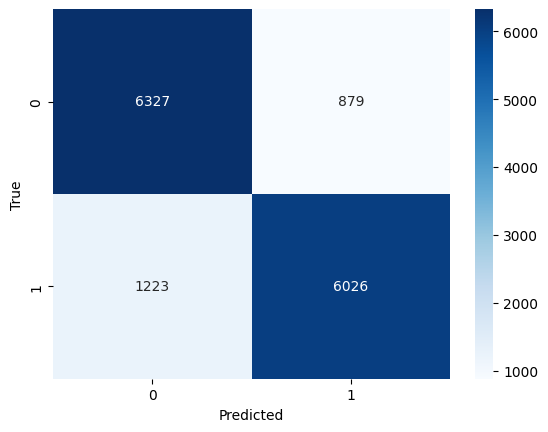

In [63]:
metricas(predicted1,y_test)

              precision    recall  f1-score   support

    negativo      0.833     0.868     0.850      7206
    positivo      0.863     0.827     0.845      7249

    accuracy                          0.848     14455
   macro avg      0.848     0.848     0.848     14455
weighted avg      0.848     0.848     0.848     14455



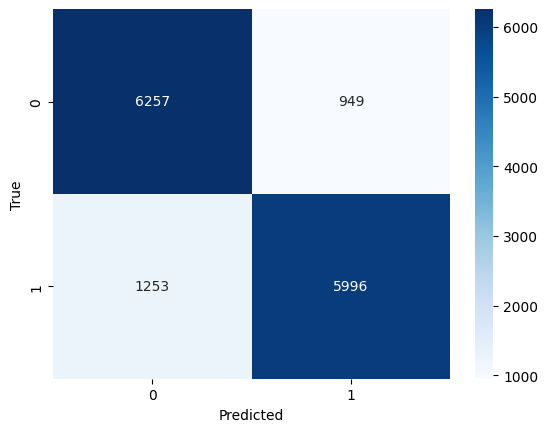

In [23]:
metricas(predicted2,y_test)

Genero las predicciones

In [64]:
guardar_y_predecir(model1,"bayes_naive_model1_filter-stop-max40000")

In [ ]:
guardar_y_predecir(model2,"bayes_naive_model1_filter-count")

TfidVectorizer dió mejores resultados, es el que voy a continuar usando

Pruebo el vectorizador con los parámetros stop words, strip_accents y max_features = 40000

              precision    recall  f1-score   support

    negativo      0.849     0.864     0.857      7206
    positivo      0.863     0.847     0.855      7249

    accuracy                          0.856     14455
   macro avg      0.856     0.856     0.856     14455
weighted avg      0.856     0.856     0.856     14455



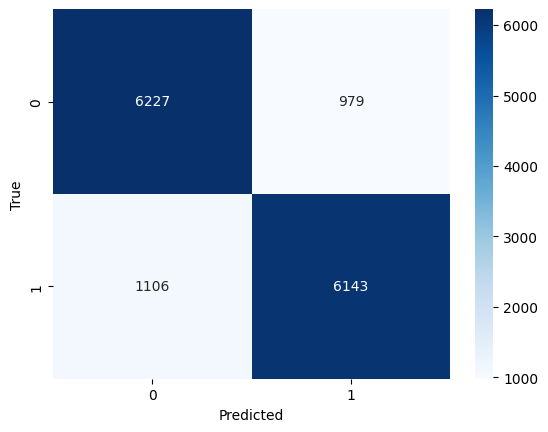

In [34]:
model1 = make_pipeline(vectorizer, MultinomialNB())
model1.fit(x_train, y_train)
predicted1 = model1.predict(x_test)
metricas(predicted1,y_test)

In [35]:
guardar_y_predecir(model1,"bayes_naive_model1_filter-stop-max40000")

Hago randomSearch para optimizar los hiperparámetros

In [41]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'multinomialnb__alpha': [0.1, 0.4, 0.5, 1.0],
    'multinomialnb__force_alpha': [True, False],
    'multinomialnb__class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
    'multinomialnb__fit_prior': [True, False]
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    MultinomialNB()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1)

#Busco los hiperparamtros que optimizan F1 Score
model= randomcv.fit(x_train,y_train)


{'multinomialnb__force_alpha': True, 'multinomialnb__fit_prior': True, 'multinomialnb__class_prior': [0.5, 0.5], 'multinomialnb__alpha': 1.0}
              precision    recall  f1-score   support

    negativo      0.851     0.861     0.856      7206
    positivo      0.860     0.850     0.855      7249

    accuracy                          0.855     14455
   macro avg      0.856     0.855     0.855     14455
weighted avg      0.856     0.855     0.855     14455



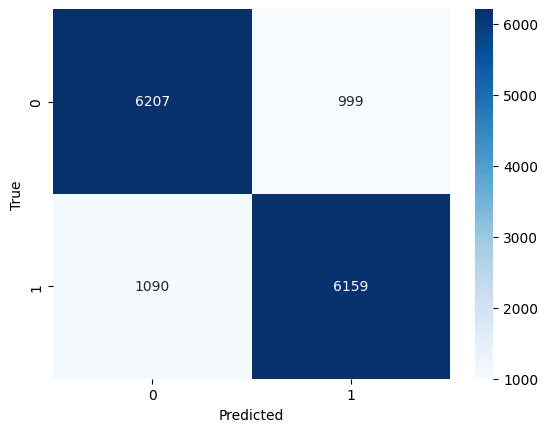

In [43]:
#Mejor estimador
best_bayes=model.best_estimator_

#Mejores parámetros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_bayes.predict(x_test)

metricas(y_pred,y_test)

In [44]:
guardar_y_predecir(best_bayes,"bayes_naive_best_model_filtrado_final")

# 2) Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Build the model
modelRF = make_pipeline(vectorizer, RandomForestClassifier(n_jobs=-1))
# Indice de frecuencia invertido. Normaliza la cantidad de palabras.
# Le da mayor importancia a las palabras que menos aparecen

# Train the model using the training data
modelRF.fit(x_train, y_train)

# Predict the categories of the test data
predicted1 = modelRF.predict(x_test)

              precision    recall  f1-score   support

    negativo      0.830     0.855     0.842      7206
    positivo      0.851     0.826     0.838      7249

    accuracy                          0.840     14455
   macro avg      0.840     0.840     0.840     14455
weighted avg      0.841     0.840     0.840     14455



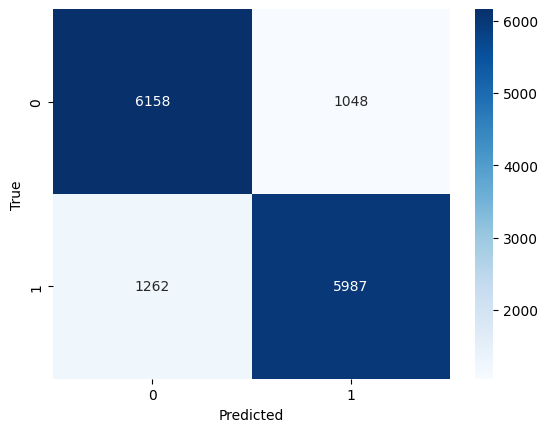

In [46]:
metricas(predicted1,y_test)

In [47]:
guardar_y_predecir(modelRF,"random_forest-filtrado")

Hago un randomsearch para optimizar los hiperparámetros

In [49]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = { "randomforestclassifier__criterion" : ["gini", "entropy"], 
                "randomforestclassifier__min_samples_leaf" : [1, 5, 10], 
                "randomforestclassifier__min_samples_split" : [2, 4, 10, 16], 
                "randomforestclassifier__n_estimators": [10, 20, 50, 100],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    RandomForestClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model = randomcv.fit(x_train,y_train)

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 16, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__criterion': 'entropy'}
              precision    recall  f1-score   support

    negativo      0.843     0.846     0.845      7206
    positivo      0.847     0.843     0.845      7249

    accuracy                          0.845     14455
   macro avg      0.845     0.845     0.845     14455
weighted avg      0.845     0.845     0.845     14455



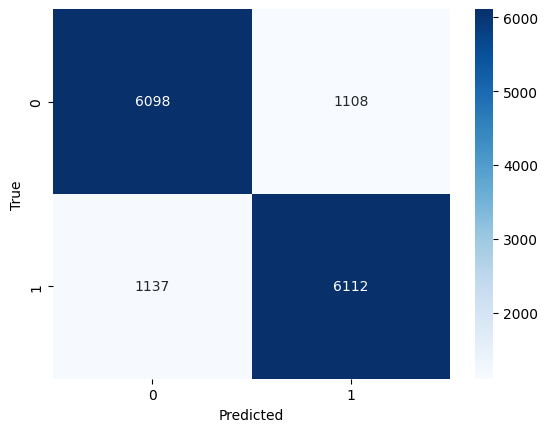

In [50]:
#Mejor estimador
best_RF=model.best_estimator_

#Mejores parametros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_RF.predict(x_test)

metricas(y_pred,y_test)

In [51]:
guardar_y_predecir(best_RF,"random_forest_best-filtrado")

# 3) XGBoost

              precision    recall  f1-score   support

           0      0.856     0.816     0.835      7206
           1      0.825     0.863     0.844      7249

    accuracy                          0.840     14455
   macro avg      0.840     0.840     0.839     14455
weighted avg      0.840     0.840     0.839     14455



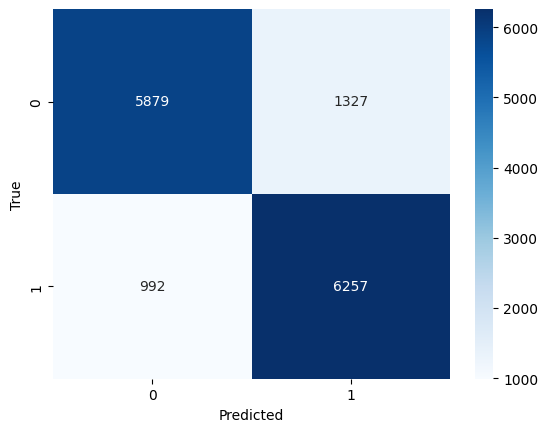

In [66]:
from xgboost import XGBClassifier
# Build the model

modelXGB = make_pipeline(vectorizer, XGBClassifier(n_jobs = -1))

# Train the model using the training data
modelXGB.fit(x_train, y_train)

# Predict the categories of the test data
predictedXGB = modelXGB.predict(x_test)

metricas(predictedXGB,y_test)

In [67]:
guardar_y_predecir(modelXGB,"XGBoost-filtrado")

Hago un randomSearch para optimizar los hiperparámetros

In [70]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.15],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__gamma': [0, 0.1, 0.5],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    XGBClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model_XGB = randomcv.fit(x_train,y_train)

In [72]:
#Mejores hiperparametros
print(model_XGB.best_params_)
#Mejor métrica
print(model_XGB.best_score_)

{'xgbclassifier__subsample': 0.8, 'xgbclassifier__reg_lambda': 0.01, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__colsample_bytree': 1.0}
0.7521479231050033


              precision    recall  f1-score   support

    negativo       0.86      0.86      0.86      7599
    positivo       0.85      0.85      0.85      7401

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



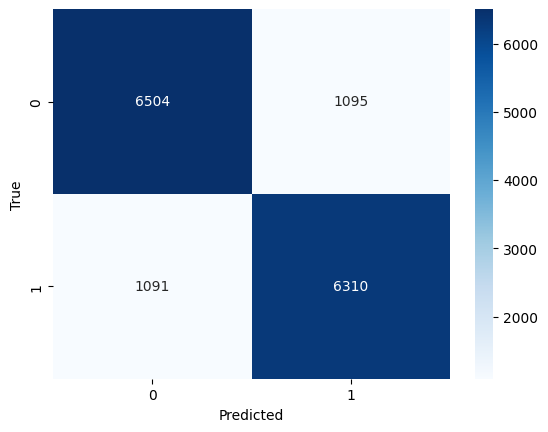

In [ ]:
#Mejor estimador
best_XGB=model_XGB.best_estimator_

#Predicción con mejor estimador
y_pred=model_XGB.predict(x_test)

metricas(y_pred,y_test)

In [ ]:
guardar_y_predecir(modelXGB,"xgboost_best-filtrado")